## Data segementation and Masking

### Additional libraries installed locally
 - pip install rasterio
 - conda install pytorch torchvision -c pytorch
 - pip install git+https://github.com/facebookresearch/segment-anything.git
 -  pip install opencv-python pycocotools matplotlib onnxruntime onnx

## Setup 

In [120]:
import numpy as np
import os
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.ops as so

from scipy import stats
import rasterio

import glob
import geopandas as gpd
import fiona
import warnings

import supervision as sv
import onnxruntime

import torch
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel
from rasterio.plot import show
from rasterio.mask import mask

from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

from jupyter_bbox_widget import BBoxWidget
%matplotlib inline

In [54]:
onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    

### Util Functions

In [9]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [53]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

### Setting the Image location

In [18]:
CURR_DIR = os.getcwd()
print("CURR_DIR : ", CURR_DIR)
os.chdir('../../')


/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio


In [35]:
DATA_DIR = os.getcwd()+'/data/xview_building_damage/images/'
print("DATA_DIR : ", DATA_DIR)
SAM_CKPT_DIR=os.getcwd()+'/data/utils/'
print("SAM_CKPT_DIR : ", SAM_CKPT_DIR)

DATA_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/images/
SAM_CKPT_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/utils/


### Reading and Displaying the image sample

In [26]:
sample_image = cv2.imread(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

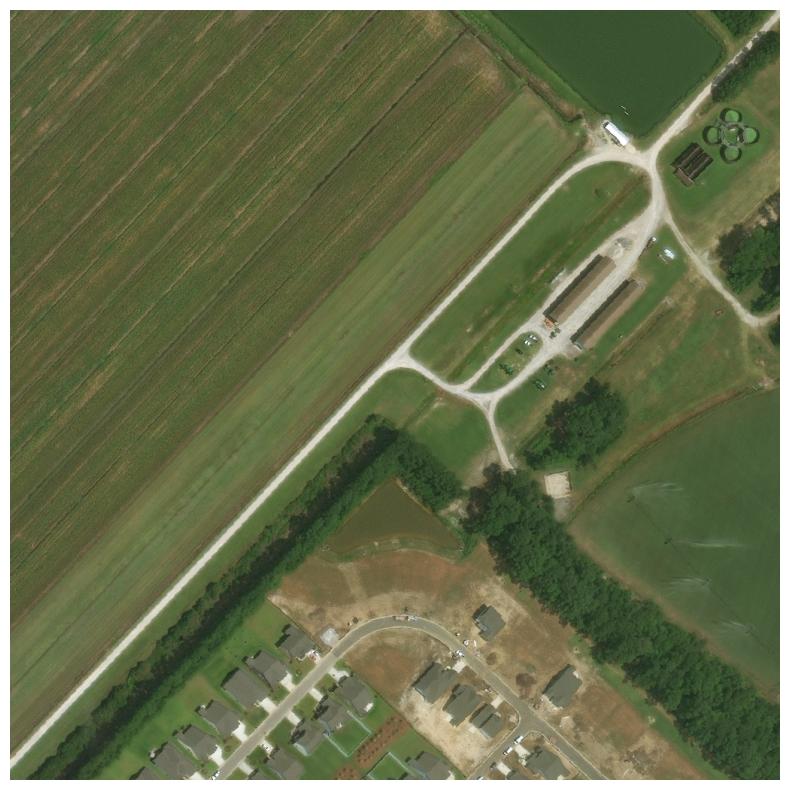

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(sample_image)
plt.axis('off')
plt.show()

### Automatic mask generation using SAM

In [47]:
sam_checkpoint = SAM_CKPT_DIR+"sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [48]:
masks = mask_generator.generate(sample_image)

In [49]:
print(len(masks))
print(masks[0].keys())

91
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


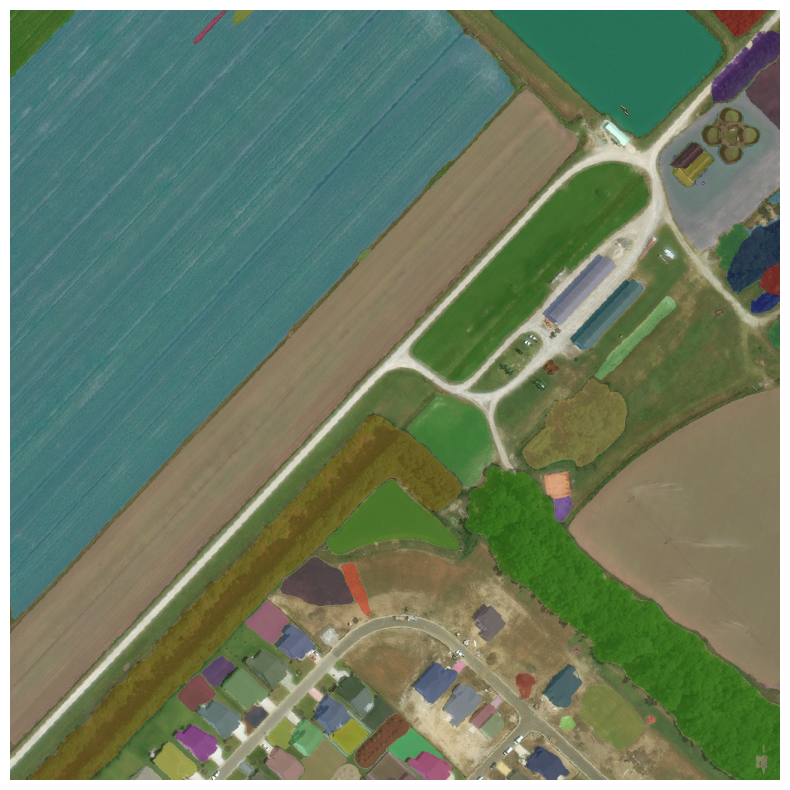

In [69]:
plt.figure(figsize=(10,10))
plt.imshow(sample_image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [67]:
mask_annotator = sv.MaskAnnotator(color_lookup = sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(masks)
annotated_image = mask_annotator.annotate(sample_image, detections)

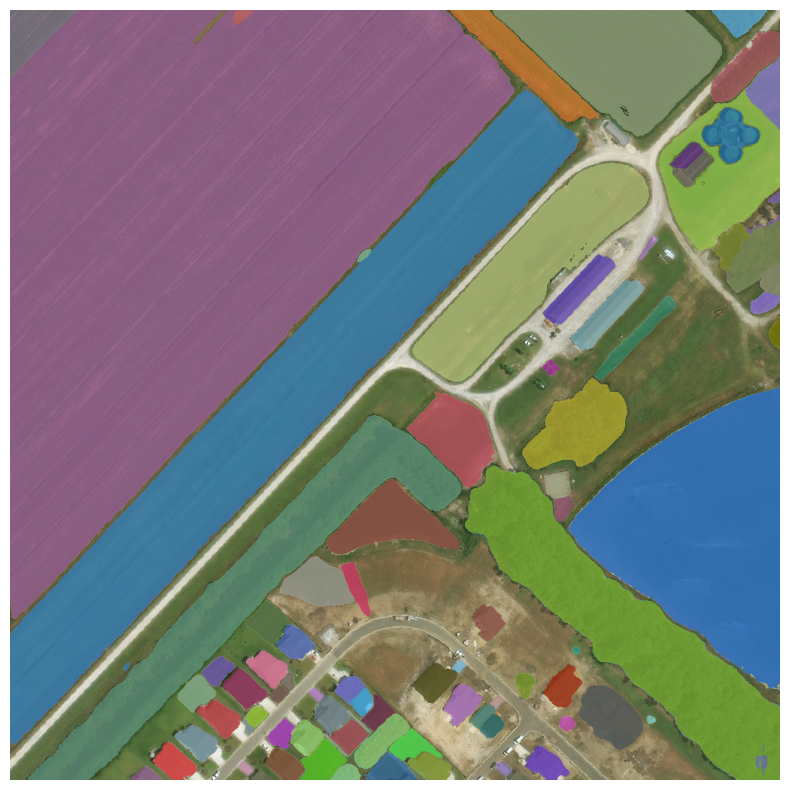

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(annotated_image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Generate Segmentation Mask with Bounding Box

In [106]:
mask_predictor = SamPredictor(sam)

image_bgr = cv2.imread(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
mask_predictor.set_image(image_rgb)

default_box = {'x': 0, 'y': 800, 'width': 600, 'height': 200, 'label': ''}
widget = BBoxWidget()
box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

#box = np.array([926,0,626,0])
masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

/var/folders/_n/997tnw7n3tdg9z81cr8j96dc0000gn/T/ipykernel_21932/1068391544.py:1: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  box_annotator = sv.BoxAnnotator(color=sv.Color.red())
/var/folders/_n/997tnw7n3tdg9z81cr8j96dc0000gn/T/ipykernel_21932/1068391544.py:2: DeprecationWarning: red is deprecated: `Color.red()` is deprecated and will be removed in `supervision-0.20.0`. Use `Color.RED` instead.
  mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)


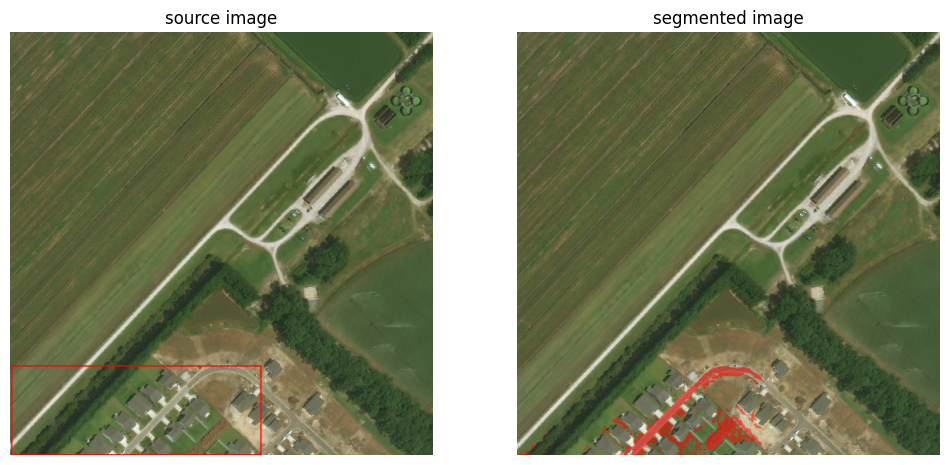

In [107]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Generating Mask using Rasterio

/Users/yaminigotimukul/anaconda3/envs/alivio/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


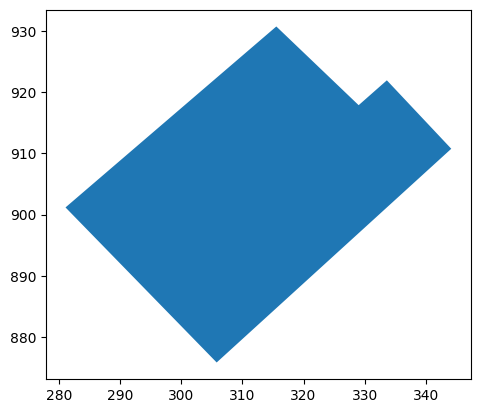

In [133]:
from shapely.wkt import loads
image = rasterio.open(DATA_DIR+'hurricane-florence_00000008_pre_disaster.png')
#bldg_poly = loads('POLYGON ((-79.04505996336113 33.65424116148868, -79.04492419817866 33.65413263811787, -79.04483519076582 33.6541312299608, -79.04475819075903 33.65419524958159, -79.0449498859919 33.65433960221093, -79.04499509050937 33.65430710163625, -79.04499216420382 33.65428986045841, -79.04501908647336 33.65427253680217, -79.04503338621484 33.65425612280632, -79.04505996336113 33.65424116148868))')
bldg_poly = loads('POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))')
p = gpd.GeoSeries(bldg_poly)
p.plot()
plt.show()

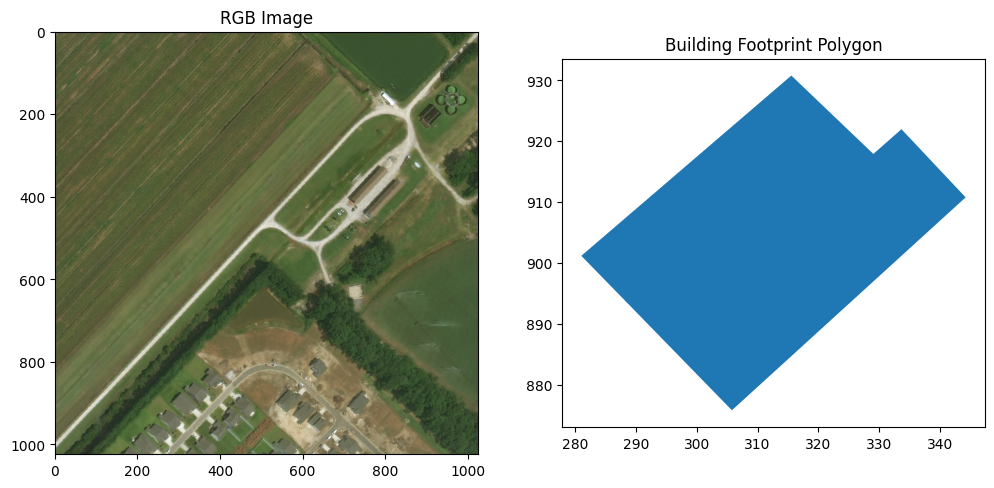

In [139]:
# Create subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot RGB image
show(image, ax=ax1)
ax1.set_title('RGB Image')

# Plot building footprint
p.plot(ax=ax2)
ax2.set_title('Building Footprint Polygon')

plt.show();